# Use of the wflow OpenStreams framework API to connect a reservoir model

### http://ops-wflow.sourceforge.net/1.0RC7/

This ipython notebook demonstrates how to load an openstreams python model, execute it step-by-step and investigate the (intermediate) results. It also shows how to re-route surface water through a reservoir model. The first steps is to load the model and framework:


In [ ]:
# First import the model. Here we use the HBV version
from wflow.wflow_sbm import *
import IPython
from IPython.display import display, clear_output
%pylab inline
#clear_output = IPython.core.display.clear_output

In [ ]:
# Here we define a simple fictious reservoir
reservoirstorage = 15000

def simplereservoir(inputq,storage):
    K = 0.087
    storage = storage + inputq
    outflow = storage * K
    storage = storage - outflow
    
    return outflow, storage

## Set model run-time parameters

 Set the:
 
 - start and time time
 - set the runid (this is where the results are stored, relative to the casename)
 - set the name of the configfile (stire in the case directory
 - set the clone mape (usually the wflow_subcatch.map)
 - set the casename. This is where all the model the model resides



In [ ]:
# define start and stop time of the run
startTime = 1
stopTime = 200
currentTime = 1
     
# set runid, cl;onemap and casename. Also define the ini file
runId = "reservoirtest_1"
#configfile="wflow_hbv_mem.ini"
configfile="wflow_sbm.ini"
wflow_cloneMap = 'wflow_subcatch.map' 

# the casename points to the complete model setup with both static and dynamic input
caseName="../../examples/wflow_rhine_sbm/"


In [ ]:
#make a usermodel object     
myModel = WflowModel(wflow_cloneMap, caseName,runId,configfile)

# initialise the framework
dynModelFw = wf_DynamicFramework(myModel, stopTime,startTime)


In [ ]:
dynModelFw.createRunId(NoOverWrite=False,level=logging.ERROR)
dynModelFw.setQuiet(1)
# Run the initial part of the model (reads parameters and sets initial values)
dynModelFw._runInitial() # Runs initial part

In [ ]:
dynModelFw._runResume() # gets the state variables from disk
# Get list of variables supplied by the model
#print dynModelFw.wf_supplyVariableNamesAndRoles()

## Here we make a pit in the middle of the main river. This will be the inflow to the reservoir

In [ ]:
# A pit can be set in the ldd by specifying the direction 5 
# (see pcraster.eu for the ldd direction conventions)
ret = dynModelFw.wf_setValueLdd("TopoLdd",5.0,8.40943,49.6682)
report(myModel.TopoLdd,"n_ldd.map")

## Run for a number of timesteps

In [ ]:
f, ax = plt.subplots(1,3,figsize=(14, 4))

plotar = []
plotarstorage = []
plotaroutflow = []

for ts in range(1,45):
        # Add inflow to outflow downstream of the pit
        # See the API setion of the INI file      
        # Get Q value at pit, the reservoir inflow
        inflowQ = dynModelFw.wf_supplyScalar("SurfaceRunoff",8.40943,49.6682)
        # save for plotting
        plotar.append(inflowQ)   
        # Feed to the reservoir model
        outflow, reservoirstorage = simplereservoir(inflowQ, reservoirstorage)
        # save for plotting
        plotarstorage.append(reservoirstorage)
        plotaroutflow.append(outflow)
        #dynModelFw._userModel().IF = cover(0.0)
        dynModelFw.wf_setValue("IF", outflow  ,8.40943,49.7085)
        # update runoff ONLY NEEDED IF YOU FIDDLE WITH THE KIN_WAVE RESERVOIR
        myModel.updateRunOff()     
        dynModelFw._runDynamic(ts,ts) # runs for this timesteps 
        # Now get some results for display
        run = dynModelFw.wf_supplyMapAsNumpy("SurfaceRunoff")
        uz = dynModelFw.wf_supplyMapAsNumpy("FirstZoneCapacity")
        sm = dynModelFw.wf_supplyMapAsNumpy("UStoreDepth")        
        sm[sm == -999] = np.nan
        uz[uz == -999] = np.nan
        run[run == -999] = np.nan
        ax[0].imshow(log(run))
        ax[1].plot(plotarstorage,'k')
        ax[1].set_title("Reservoir storage")
        ax[2].plot(plotar,'b')
        ax[2].plot(plotaroutflow,'r')
        
        ax[2].set_title("Blue inflow, red outflow:" + str(ts))
        clear_output()
        display(f)
        
plt.close()

In [ ]:
dynModelFw._runSuspend() # saves the state variables
dynModelFw._wf_shutdown()

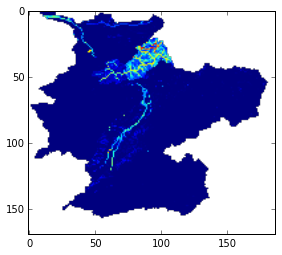

In [13]:
imshow(dynModelFw.wf_supplyMapAsNumpy("UStoreDepth"))